# Quantified Self  
## 1. Introduction  
The domain for this project is my Google Maps data, specifically my Semantic Location Data. I was interested in doing research on this data because I wanted to see if I have different movement habits during different seasons. Last Spring I studied abroad, and I am curious to see if my movement patterns were different there than they are in Spokane.  

The dataset is in multiple JSON files which are seperated by month. The tables that I am inclding from the dataset are ...... The data in each table is collected....There are .. instances.  

* Study abroad dates: jan 21 2022 - may 5 2022 (excluding days at the airport)
* Spokane sample (summer): May 22 2022 - Aug 14 2022
## 2. Data Analysis
### I. Data Loading  
The first step is to load the data from JSON format into two Pandas dataframes--one for my time studying abroad in Spain, and one for my Summer in Spokane. 

I used [`pd.concat()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html) to combine the different months.

##### *notes: use pd.to_datetime, use "format" if needed. make new col (df_date = date_list), where datelist uses for loop to get all dates (datelist.append(d.date)),also make graphs

In [162]:
import pandas as pd
import utils 
import importlib
importlib.reload(utils) # to reload utils every time

jan_aug_df = pd.DataFrame()

months = ["JANUARY", "FEBRUARY", "MARCH", "APRIL", "MAY", "JUNE", "JULY", "AUGUST"]
for item in months:
    jan_aug_df = pd.concat([jan_aug_df, pd.read_json("../Semantic Location History/2022/2022_" + item + ".json")])

#send to new json file
jan_aug_df.to_csv("jan_to_aug.csv")

### II. Data cleaning
In this section, I will clean my Google Maps Semantic Location Data and send it to a csv file that will have meaningful column headers and only contains the information we want. 

#### a. Split Into Two Dataframes

In [163]:
print(type(jan_aug_df["timelineObjects"].iloc[0]))

# this is json data (dictionary)

<class 'dict'>


In [164]:
# need to grab dates from 2022-01-21 to 2022-01-31, 2022-02-xx, 2022-03-xx, 2022-04-xx, and through 2022-05-05

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

utils.get_start_end(jan_aug_df, "2022-01-21", "2022-05-05")

118
120
122
124
126
128
130
132
134
136
137
1316
1318
1320
1321
1322
1324
1326
1328
1329
1331
1333


In [165]:
start = 118
end = 1333

study_abroad_df = utils.make_dataframe(jan_aug_df, start, end)
study_abroad_df

,Start Timestamp,End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance,Activity,Confidence
0,2022-01-21T09:13:23Z,2022-01-21T09:20:45.491Z,404072887,-37037391,404118401,-37052917,634,WALKING,HIGH
1,2022-01-21T10:58:40.449Z,2022-01-21T11:23:11.776Z,404124269,-37045765,404083941,-36930145,1289,WALKING,HIGH
2,2022-01-21T11:31:20.770Z,2022-01-21T12:22:11.361Z,404095404,-36928230,404181546,-37046289,2670,WALKING,HIGH
3,2022-01-21T12:29:27.539Z,2022-01-21T12:40:28.366Z,404167013,-37044784,404185364,-37098021,607,WALKING,HIGH
4,2022-01-21T14:40:28.840Z,2022-01-21T14:48:36.275Z,404163340,-37087356,404161470,-37032274,499,WALKING,HIGH
...,...,...,...,...,...,...,...,...,...
637,2022-05-05T14:32:53.709Z,2022-05-05T14:34:57.181Z,404182319,-37095123,404202932,-37059859,376,IN_SUBWAY,HIGH
638,2022-05-05T14:40:04.529Z,2022-05-05T14:51:58.837Z,404203902,-37063509,404069457,-37037075,2149,IN_SUBWAY,MEDIUM
639,2022-05-05T17:24:51.042Z,2022-05-05T17:38:07.070Z,404066533,-37035654,404047651,-37023939,610,WALKING,LOW
640,2022-05-05T17:38:07.070Z,2022-05-05T17:52:17.360Z,404047651,-37023939,404262112,-37011621,2438,IN_SUBWAY,LOW


In [166]:
# get summer data- 2022-05-22 through 2022-08-14

utils.get_start_end(jan_aug_df, "2022-05-22", "2022-08-14")


1491
1493
2210
2212
2214
2216


In [167]:
start = 1491
end = 2216

summer_df = utils.make_dataframe(jan_aug_df, start, end)
summer_df

,Start Timestamp,End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance,Activity,Confidence
0,2022-05-22T00:26:53.487Z,2022-05-22T01:04:16.530Z,477019914,-1174127539,478158715,-1173468857,16009,IN_PASSENGER_VEHICLE,HIGH
1,2022-05-22T21:48:14Z,2022-05-22T22:05:39Z,478566574,-1172777957,477719874,-1174023325,19129,IN_PASSENGER_VEHICLE,HIGH
2,2022-05-23T00:27:20Z,2022-05-23T00:47:08.449Z,477731568,-1174029817,478561191,-1172749742,17875,IN_PASSENGER_VEHICLE,HIGH
3,2022-05-23T16:16:00.836Z,2022-05-23T16:58:48.051Z,478561216,-1172749754,476676638,-1174008391,28584,IN_PASSENGER_VEHICLE,HIGH
4,2022-05-23T23:08:05.143Z,2022-05-23T23:44:36.050Z,476684577,-1174024072,478407460,-1173540569,20647,IN_PASSENGER_VEHICLE,HIGH
...,...,...,...,...,...,...,...,...,...
358,2022-08-13T01:38:03.467Z,2022-08-13T02:52:07.291Z,476747573,-1173909960,478560977,-1172754508,26251,IN_PASSENGER_VEHICLE,HIGH
359,2022-08-13T03:20:43.385Z,2022-08-13T04:13:20.389Z,478562593,-1172756483,476747751,-1173905676,22070,IN_PASSENGER_VEHICLE,HIGH
360,2022-08-14T01:08:02.334Z,2022-08-14T01:24:07Z,476748260,-1173907931,476438752,-1174103693,5487,IN_PASSENGER_VEHICLE,HIGH
361,2022-08-14T03:29:46Z,2022-08-14T03:41:20Z,476451787,-1174110853,476748346,-1173911600,4849,IN_PASSENGER_VEHICLE,HIGH


#### b. Convert Timestamps to DateTime 

In [168]:

start_fixed = pd.to_datetime(summer_df["Start Timestamp"])
end_fixed = pd.to_datetime(summer_df["End Timestamp"])

summer_df["Start Timestamp"] = start_fixed
summer_df["End Timestamp"] = end_fixed

summer_df

,Start Timestamp,End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance,Activity,Confidence
0,2022-05-22 00:26:53.487000+00:00,2022-05-22 01:04:16.530000+00:00,477019914,-1174127539,478158715,-1173468857,16009,IN_PASSENGER_VEHICLE,HIGH
1,2022-05-22 21:48:14+00:00,2022-05-22 22:05:39+00:00,478566574,-1172777957,477719874,-1174023325,19129,IN_PASSENGER_VEHICLE,HIGH
2,2022-05-23 00:27:20+00:00,2022-05-23 00:47:08.449000+00:00,477731568,-1174029817,478561191,-1172749742,17875,IN_PASSENGER_VEHICLE,HIGH
3,2022-05-23 16:16:00.836000+00:00,2022-05-23 16:58:48.051000+00:00,478561216,-1172749754,476676638,-1174008391,28584,IN_PASSENGER_VEHICLE,HIGH
4,2022-05-23 23:08:05.143000+00:00,2022-05-23 23:44:36.050000+00:00,476684577,-1174024072,478407460,-1173540569,20647,IN_PASSENGER_VEHICLE,HIGH
...,...,...,...,...,...,...,...,...,...
358,2022-08-13 01:38:03.467000+00:00,2022-08-13 02:52:07.291000+00:00,476747573,-1173909960,478560977,-1172754508,26251,IN_PASSENGER_VEHICLE,HIGH
359,2022-08-13 03:20:43.385000+00:00,2022-08-13 04:13:20.389000+00:00,478562593,-1172756483,476747751,-1173905676,22070,IN_PASSENGER_VEHICLE,HIGH
360,2022-08-14 01:08:02.334000+00:00,2022-08-14 01:24:07+00:00,476748260,-1173907931,476438752,-1174103693,5487,IN_PASSENGER_VEHICLE,HIGH
361,2022-08-14 03:29:46+00:00,2022-08-14 03:41:20+00:00,476451787,-1174110853,476748346,-1173911600,4849,IN_PASSENGER_VEHICLE,HIGH


In [169]:
start_fixed = pd.to_datetime(study_abroad_df["Start Timestamp"])
end_fixed = pd.to_datetime(study_abroad_df["End Timestamp"])

study_abroad_df["Start Timestamp"] = start_fixed
study_abroad_df["End Timestamp"] = end_fixed

study_abroad_df

,Start Timestamp,End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance,Activity,Confidence
0,2022-01-21 09:13:23+00:00,2022-01-21 09:20:45.491000+00:00,404072887,-37037391,404118401,-37052917,634,WALKING,HIGH
1,2022-01-21 10:58:40.449000+00:00,2022-01-21 11:23:11.776000+00:00,404124269,-37045765,404083941,-36930145,1289,WALKING,HIGH
2,2022-01-21 11:31:20.770000+00:00,2022-01-21 12:22:11.361000+00:00,404095404,-36928230,404181546,-37046289,2670,WALKING,HIGH
3,2022-01-21 12:29:27.539000+00:00,2022-01-21 12:40:28.366000+00:00,404167013,-37044784,404185364,-37098021,607,WALKING,HIGH
4,2022-01-21 14:40:28.840000+00:00,2022-01-21 14:48:36.275000+00:00,404163340,-37087356,404161470,-37032274,499,WALKING,HIGH
...,...,...,...,...,...,...,...,...,...
637,2022-05-05 14:32:53.709000+00:00,2022-05-05 14:34:57.181000+00:00,404182319,-37095123,404202932,-37059859,376,IN_SUBWAY,HIGH
638,2022-05-05 14:40:04.529000+00:00,2022-05-05 14:51:58.837000+00:00,404203902,-37063509,404069457,-37037075,2149,IN_SUBWAY,MEDIUM
639,2022-05-05 17:24:51.042000+00:00,2022-05-05 17:38:07.070000+00:00,404066533,-37035654,404047651,-37023939,610,WALKING,LOW
640,2022-05-05 17:38:07.070000+00:00,2022-05-05 17:52:17.360000+00:00,404047651,-37023939,404262112,-37011621,2438,IN_SUBWAY,LOW


Lets parse the timestamps for just the date. used [strftime()](https://www.programiz.com/python-programming/datetime/strftime)

In [170]:
date_lst = []
for item in study_abroad_df["Start Timestamp"]:
    date_lst.append((item.date().strftime("%Y-%m-%d")))
date_lst

# add col
study_abroad_df.insert(column="Date", value=date_lst, loc=0)
study_abroad_df

,Date,Start Timestamp,End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance,Activity,Confidence
0,2022-01-21,2022-01-21 09:13:23+00:00,2022-01-21 09:20:45.491000+00:00,404072887,-37037391,404118401,-37052917,634,WALKING,HIGH
1,2022-01-21,2022-01-21 10:58:40.449000+00:00,2022-01-21 11:23:11.776000+00:00,404124269,-37045765,404083941,-36930145,1289,WALKING,HIGH
2,2022-01-21,2022-01-21 11:31:20.770000+00:00,2022-01-21 12:22:11.361000+00:00,404095404,-36928230,404181546,-37046289,2670,WALKING,HIGH
3,2022-01-21,2022-01-21 12:29:27.539000+00:00,2022-01-21 12:40:28.366000+00:00,404167013,-37044784,404185364,-37098021,607,WALKING,HIGH
4,2022-01-21,2022-01-21 14:40:28.840000+00:00,2022-01-21 14:48:36.275000+00:00,404163340,-37087356,404161470,-37032274,499,WALKING,HIGH
...,...,...,...,...,...,...,...,...,...,...
637,2022-05-05,2022-05-05 14:32:53.709000+00:00,2022-05-05 14:34:57.181000+00:00,404182319,-37095123,404202932,-37059859,376,IN_SUBWAY,HIGH
638,2022-05-05,2022-05-05 14:40:04.529000+00:00,2022-05-05 14:51:58.837000+00:00,404203902,-37063509,404069457,-37037075,2149,IN_SUBWAY,MEDIUM
639,2022-05-05,2022-05-05 17:24:51.042000+00:00,2022-05-05 17:38:07.070000+00:00,404066533,-37035654,404047651,-37023939,610,WALKING,LOW
640,2022-05-05,2022-05-05 17:38:07.070000+00:00,2022-05-05 17:52:17.360000+00:00,404047651,-37023939,404262112,-37011621,2438,IN_SUBWAY,LOW


#### c. fix Latitude and Longitude Columns  

In [171]:
#madrid
fixed_start_lat_lst = utils.fix_lat_lon(study_abroad_df, "Start Latitude", 2)
study_abroad_df["Start Latitude"] = fixed_start_lat_lst

fixed_start_lon_lst = utils.fix_lat_lon(study_abroad_df, "Start Longitude", 1)
study_abroad_df["Start Longitude"] = fixed_start_lon_lst

fixed_end_lat_lst = utils.fix_lat_lon(study_abroad_df, "End Latitude", 2)
study_abroad_df["End Latitude"] = fixed_end_lat_lst

fixed_end_lon_lst = utils.fix_lat_lon(study_abroad_df, "End Longitude", 1)
study_abroad_df["End Longitude"] = fixed_end_lon_lst
study_abroad_df
study_abroad_df.to_csv("study_abroad.csv")

#spokane
fixed_start_lat_lst = utils.fix_lat_lon(summer_df, "Start Latitude", 2)
summer_df["Start Latitude"] = fixed_start_lat_lst

fixed_start_lon_lst = utils.fix_lat_lon(summer_df, "Start Longitude", 3)
summer_df["Start Longitude"] = fixed_start_lon_lst

fixed_end_lat_lst = utils.fix_lat_lon(summer_df, "End Latitude", 2)
summer_df["End Latitude"] = fixed_end_lat_lst

fixed_end_lon_lst = utils.fix_lat_lon(summer_df, "End Longitude", 3)
summer_df["End Longitude"] = fixed_end_lon_lst
summer_df.to_csv("summer_spokane.csv")
summer_df


,Start Timestamp,End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance,Activity,Confidence
0,2022-05-22 00:26:53.487000+00:00,2022-05-22 01:04:16.530000+00:00,47.7019914,-117.4127539,47.8158715,-117.3468857,16009,IN_PASSENGER_VEHICLE,HIGH
1,2022-05-22 21:48:14+00:00,2022-05-22 22:05:39+00:00,47.8566574,-117.2777957,47.7719874,-117.4023325,19129,IN_PASSENGER_VEHICLE,HIGH
2,2022-05-23 00:27:20+00:00,2022-05-23 00:47:08.449000+00:00,47.7731568,-117.4029817,47.8561191,-117.2749742,17875,IN_PASSENGER_VEHICLE,HIGH
3,2022-05-23 16:16:00.836000+00:00,2022-05-23 16:58:48.051000+00:00,47.8561216,-117.2749754,47.6676638,-117.4008391,28584,IN_PASSENGER_VEHICLE,HIGH
4,2022-05-23 23:08:05.143000+00:00,2022-05-23 23:44:36.050000+00:00,47.6684577,-117.4024072,47.8407460,-117.3540569,20647,IN_PASSENGER_VEHICLE,HIGH
...,...,...,...,...,...,...,...,...,...
358,2022-08-13 01:38:03.467000+00:00,2022-08-13 02:52:07.291000+00:00,47.6747573,-117.3909960,47.8560977,-117.2754508,26251,IN_PASSENGER_VEHICLE,HIGH
359,2022-08-13 03:20:43.385000+00:00,2022-08-13 04:13:20.389000+00:00,47.8562593,-117.2756483,47.6747751,-117.3905676,22070,IN_PASSENGER_VEHICLE,HIGH
360,2022-08-14 01:08:02.334000+00:00,2022-08-14 01:24:07+00:00,47.6748260,-117.3907931,47.6438752,-117.4103693,5487,IN_PASSENGER_VEHICLE,HIGH
361,2022-08-14 03:29:46+00:00,2022-08-14 03:41:20+00:00,47.6451787,-117.4110853,47.6748346,-117.3911600,4849,IN_PASSENGER_VEHICLE,HIGH


#### get total time for each activity segment

In [172]:
dif_ser = study_abroad_df["End Timestamp"] - study_abroad_df["Start Timestamp"]
dif_sec_lst= []

for i in range(dif_ser.size):
    dif_sec_lst.append(dif_ser.iloc[i].total_seconds())
# do this in loop
dif_sec_lst

#convert to min
dif_ser_min = pd.Series(dif_sec_lst)
dif_ser_min/= 60

# # add col
study_abroad_df.insert(column="Time Elapsed (min)", value=dif_ser_min, loc=2)
study_abroad_df

,Date,Start Timestamp,Time Elapsed (min),End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance,Activity,Confidence
0,2022-01-21,2022-01-21 09:13:23+00:00,7.374850,2022-01-21 09:20:45.491000+00:00,40.4072887,-3.7037391,40.4118401,-3.7052917,634,WALKING,HIGH
1,2022-01-21,2022-01-21 10:58:40.449000+00:00,24.522117,2022-01-21 11:23:11.776000+00:00,40.4124269,-3.7045765,40.4083941,-3.6930145,1289,WALKING,HIGH
2,2022-01-21,2022-01-21 11:31:20.770000+00:00,50.843183,2022-01-21 12:22:11.361000+00:00,40.4095404,-3.6928230,40.4181546,-3.7046289,2670,WALKING,HIGH
3,2022-01-21,2022-01-21 12:29:27.539000+00:00,11.013783,2022-01-21 12:40:28.366000+00:00,40.4167013,-3.7044784,40.4185364,-3.7098021,607,WALKING,HIGH
4,2022-01-21,2022-01-21 14:40:28.840000+00:00,8.123917,2022-01-21 14:48:36.275000+00:00,40.4163340,-3.7087356,40.4161470,-3.7032274,499,WALKING,HIGH
...,...,...,...,...,...,...,...,...,...,...,...
637,2022-05-05,2022-05-05 14:32:53.709000+00:00,2.057867,2022-05-05 14:34:57.181000+00:00,40.4182319,-3.7095123,40.4202932,-3.7059859,376,IN_SUBWAY,HIGH
638,2022-05-05,2022-05-05 14:40:04.529000+00:00,11.905133,2022-05-05 14:51:58.837000+00:00,40.4203902,-3.7063509,40.4069457,-3.7037075,2149,IN_SUBWAY,MEDIUM
639,2022-05-05,2022-05-05 17:24:51.042000+00:00,13.267133,2022-05-05 17:38:07.070000+00:00,40.4066533,-3.7035654,40.4047651,-3.7023939,610,WALKING,LOW
640,2022-05-05,2022-05-05 17:38:07.070000+00:00,14.171500,2022-05-05 17:52:17.360000+00:00,40.4047651,-3.7023939,40.4262112,-3.7011621,2438,IN_SUBWAY,LOW


In [173]:
dif_ser = summer_df["End Timestamp"] - summer_df["Start Timestamp"]
dif_sec_lst= []

for i in range(dif_ser.size):
    dif_sec_lst.append(dif_ser.iloc[i].total_seconds())
# do this in loop
dif_sec_lst

#convert to min
dif_ser_min = pd.Series(dif_sec_lst)
dif_ser_min/= 60

# add col
summer_df.insert(column="Time Elapsed (min)", value=dif_ser_min, loc=2)
summer_df

,Start Timestamp,End Timestamp,Time Elapsed (min),Start Latitude,Start Longitude,End Latitude,End Longitude,Distance,Activity,Confidence
0,2022-05-22 00:26:53.487000+00:00,2022-05-22 01:04:16.530000+00:00,37.384050,47.7019914,-117.4127539,47.8158715,-117.3468857,16009,IN_PASSENGER_VEHICLE,HIGH
1,2022-05-22 21:48:14+00:00,2022-05-22 22:05:39+00:00,17.416667,47.8566574,-117.2777957,47.7719874,-117.4023325,19129,IN_PASSENGER_VEHICLE,HIGH
2,2022-05-23 00:27:20+00:00,2022-05-23 00:47:08.449000+00:00,19.807483,47.7731568,-117.4029817,47.8561191,-117.2749742,17875,IN_PASSENGER_VEHICLE,HIGH
3,2022-05-23 16:16:00.836000+00:00,2022-05-23 16:58:48.051000+00:00,42.786917,47.8561216,-117.2749754,47.6676638,-117.4008391,28584,IN_PASSENGER_VEHICLE,HIGH
4,2022-05-23 23:08:05.143000+00:00,2022-05-23 23:44:36.050000+00:00,36.515117,47.6684577,-117.4024072,47.8407460,-117.3540569,20647,IN_PASSENGER_VEHICLE,HIGH
...,...,...,...,...,...,...,...,...,...,...
358,2022-08-13 01:38:03.467000+00:00,2022-08-13 02:52:07.291000+00:00,74.063733,47.6747573,-117.3909960,47.8560977,-117.2754508,26251,IN_PASSENGER_VEHICLE,HIGH
359,2022-08-13 03:20:43.385000+00:00,2022-08-13 04:13:20.389000+00:00,52.616733,47.8562593,-117.2756483,47.6747751,-117.3905676,22070,IN_PASSENGER_VEHICLE,HIGH
360,2022-08-14 01:08:02.334000+00:00,2022-08-14 01:24:07+00:00,16.077767,47.6748260,-117.3907931,47.6438752,-117.4103693,5487,IN_PASSENGER_VEHICLE,HIGH
361,2022-08-14 03:29:46+00:00,2022-08-14 03:41:20+00:00,11.566667,47.6451787,-117.4110853,47.6748346,-117.3911600,4849,IN_PASSENGER_VEHICLE,HIGH


Now I will join my dataframes with weather data using the Meteostat API. I will use the "Date" column and the "Start Latitude" and "Start Latitude" columns in order to get the nearest weather station. first lets initialize my API key and headers.

In [174]:

weather_df = pd.read_csv("daily_weather_madrid.csv")
weather_df

,Unnamed: 0,Date,Avg Temp,Min Temp,Max Temp,Precip.,Snow,Wind Dir.,Wind Speed,Peak Wind Gust,Pressure,Total Sun
0,0,2022-01-21,40.8,33.8,48.0,0.000,NaN,32.0,6.6,NaN,1027.9,NaN
1,1,2022-01-22,41.0,34.2,48.7,0.000,NaN,37.0,6.5,NaN,1030.8,NaN
2,2,2022-01-23,42.4,36.3,48.7,0.000,NaN,49.0,5.3,NaN,1028.1,NaN
3,3,2022-01-24,43.9,39.2,47.3,0.000,NaN,40.0,4.9,NaN,1028.8,NaN
4,4,2022-01-25,46.2,39.7,50.7,0.000,NaN,62.0,5.5,NaN,1031.7,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
100,100,2022-05-01,62.4,55.2,77.9,0.000,NaN,321.0,4.7,NaN,1017.8,NaN
101,101,2022-05-02,57.6,53.6,66.9,0.087,NaN,8.0,6.5,NaN,1011.2,NaN
102,102,2022-05-03,55.9,52.0,63.5,0.102,NaN,50.0,10.8,NaN,1011.8,NaN
103,103,2022-05-04,57.7,50.4,68.4,0.000,NaN,42.0,9.8,NaN,1016.1,NaN


In [175]:
merged_df = study_abroad_df.merge(weather_df, how='inner', on="Date")
merged_df

,Date,Start Timestamp,Time Elapsed (min),End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance,Activity,...,Avg Temp,Min Temp,Max Temp,Precip.,Snow,Wind Dir.,Wind Speed,Peak Wind Gust,Pressure,Total Sun
0,2022-01-21,2022-01-21 09:13:23+00:00,7.374850,2022-01-21 09:20:45.491000+00:00,40.4072887,-3.7037391,40.4118401,-3.7052917,634,WALKING,...,40.8,33.8,48.0,0.0,NaN,32.0,6.6,NaN,1027.9,NaN
1,2022-01-21,2022-01-21 10:58:40.449000+00:00,24.522117,2022-01-21 11:23:11.776000+00:00,40.4124269,-3.7045765,40.4083941,-3.6930145,1289,WALKING,...,40.8,33.8,48.0,0.0,NaN,32.0,6.6,NaN,1027.9,NaN
2,2022-01-21,2022-01-21 11:31:20.770000+00:00,50.843183,2022-01-21 12:22:11.361000+00:00,40.4095404,-3.6928230,40.4181546,-3.7046289,2670,WALKING,...,40.8,33.8,48.0,0.0,NaN,32.0,6.6,NaN,1027.9,NaN
3,2022-01-21,2022-01-21 12:29:27.539000+00:00,11.013783,2022-01-21 12:40:28.366000+00:00,40.4167013,-3.7044784,40.4185364,-3.7098021,607,WALKING,...,40.8,33.8,48.0,0.0,NaN,32.0,6.6,NaN,1027.9,NaN
4,2022-01-21,2022-01-21 14:40:28.840000+00:00,8.123917,2022-01-21 14:48:36.275000+00:00,40.4163340,-3.7087356,40.4161470,-3.7032274,499,WALKING,...,40.8,33.8,48.0,0.0,NaN,32.0,6.6,NaN,1027.9,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,2022-05-05,2022-05-05 14:32:53.709000+00:00,2.057867,2022-05-05 14:34:57.181000+00:00,40.4182319,-3.7095123,40.4202932,-3.7059859,376,IN_SUBWAY,...,58.8,51.1,74.1,0.0,NaN,27.0,5.4,NaN,1021.3,NaN
638,2022-05-05,2022-05-05 14:40:04.529000+00:00,11.905133,2022-05-05 14:51:58.837000+00:00,40.4203902,-3.7063509,40.4069457,-3.7037075,2149,IN_SUBWAY,...,58.8,51.1,74.1,0.0,NaN,27.0,5.4,NaN,1021.3,NaN
639,2022-05-05,2022-05-05 17:24:51.042000+00:00,13.267133,2022-05-05 17:38:07.070000+00:00,40.4066533,-3.7035654,40.4047651,-3.7023939,610,WALKING,...,58.8,51.1,74.1,0.0,NaN,27.0,5.4,NaN,1021.3,NaN
640,2022-05-05,2022-05-05 17:38:07.070000+00:00,14.171500,2022-05-05 17:52:17.360000+00:00,40.4047651,-3.7023939,40.4262112,-3.7011621,2438,IN_SUBWAY,...,58.8,51.1,74.1,0.0,NaN,27.0,5.4,NaN,1021.3,NaN


### IV. Hypothesis Testing  
#### Test 1: Two Sample One Tailed Independent T Test of Mean Distance of Activity Segments 
* using my Google Maps dataset, I am going to see if the mean distance of my activity segments in Spain was greater than the mean distance of my activity segments in Spokane over the Summer.
* my significance level $\alpha$ will be 0.05.

Here are the formulas I will be using (independent, one tailed):
###### $$t = \frac{\overline{X}_{1} - \overline{X}_{2}}{\sqrt{S_{p}{2}(\frac{1}{n_{1}} + \frac{1}{n_{2}})}}$$

###### $$S_{p}^{2} = \frac{(n_{1} - 1)s_{1}^{2} + (n_{2} - 1)s_{2}^{2}}{n_{1} + n_{2} - 2}$$  
df = n1 + n2 - 2  
Lets find the degrees of freedom.

In [176]:
# n for both samples:
sa_n = study_abroad_df["Distance"].size
print(sa_n)

sum_n = summer_df["Distance"].size
print(sum_n)
df = sa_n + sum_n - 2
print("Degrees of freedom is", df)

642
363
Degrees of freedom is 1003


**Step 1: Identify $H_{0}$ and $H_1$**  
$H_{0}$ : $\mu_{Spain} \leq \mu_{Spokane}$   
$H_1$  : $\mu_{Spain} > \mu_{Spokane}$

**Step 2: Select Level of Significance**  
$\alpha$ = 0.05, meaning there is a 5% chance of making an error when rejecting the null hypothesis

In [177]:
alpha = 0.05

**Step 3: Select appropriate test statistic**  
for a one tailed, two sample independent t-test with $\alpha$ value 0.05 and df = 1003.
using a t-chart, t is about 1.6469.

In [178]:
t_crit = 1.6469

**Step 4: formulate the _decision rule_**

If $t_{computed} \leq$ 1.6469, do not reject $H_{0}$-->The population mean distance of activity segments in Spain is less than or equal to the population mean distance of activity segments in Spokane.   
If $t_{computed} >$ 1.6469, reject $H_{0}$-->The population mean distance of activity segments in Spain is greater than the population mean distance of activity segments in Spokane.

**Step 5: Make a Decision**  
* find $t_{computed}$

* apply decision rule

In [179]:
from scipy import stats

# get t and pvalue
t_comp, p_val = stats.ttest_ind(summer_df["Distance"], study_abroad_df["Distance"])
p_val/=2
print("T is", f"{t_comp:.4f}", ", and p-value is", f"{p_val:.4f}")

# apply decision rule by testing pvalue
if(p_val < alpha):
     print("Reject H0. The population mean distance of activity segments in Spain is greater than the population mean distance of activity segments in Spokane")
else:
    print("Do not reject H0. The population mean distance of activity segments in Spain is less than or equal to the population mean distance of activity segments in Spokane.")

T is 0.5531 , and p-value is 0.2901
Do not reject H0. The population mean distance of activity segments in Spain is less than or equal to the population mean distance of activity segments in Spokane.


#### Test 2: Two Sample One-tailed Independent T Test of Mean Travel Activity  
* here I will be testing the mean travel activity between Spain and Spokane
* I will need to change the categorical travel activity data to numerical data using `sklearn.preprocessing.LabelEncoder()`.
* lets concatenate the two dataframes first for consistent encoding

In [180]:
combined_df = pd.concat([study_abroad_df, summer_df])

In [181]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X = combined_df
le.fit(X["Activity"])
#list(le.classes_)
arr = le.transform(X["Activity"])

X["Activity"] = arr
X.to_csv("test.csv")
#print(X.iloc[641])

study_abroad_act_num = []
summer_act_num = []
#add to original dfs
for i in range(642):
    study_abroad_act_num.append(X["Activity"].iloc[i])
for i in range(642, X["Activity"].size):
    summer_act_num.append(X["Activity"].iloc[i])

# replace original activity cols
study_abroad_df["Activity"] = study_abroad_act_num
summer_df["Activity"] = summer_act_num


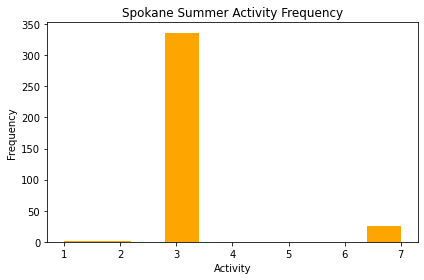

In [182]:
import matplotlib.pyplot as plt

# labels
#plt.xticks(rotation=45, ha="right") # ha: horizontal alignment
plt.title("Spokane Summer Activity Frequency")
plt.xlabel("Activity")
plt.ylabel("Frequency")

# plot 
plt.hist(summer_df["Activity"], color="orange")
plt.tight_layout()
plt.show()

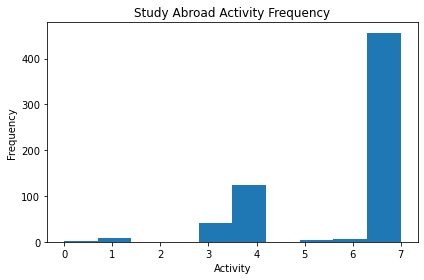

In [183]:
# new figure
plt.figure()

# labels
#plt.xticks(rotation=45, ha="right") # ha: horizontal alignment
plt.title("Study Abroad Activity Frequency")
plt.xlabel("Activity")
plt.ylabel("Frequency")

# plot 
plt.hist(study_abroad_df["Activity"])

plt.tight_layout()
plt.show()



Here are the formulas I will be using (independent, one tailed):
###### $$t = \frac{\overline{X}_{1} - \overline{X}_{2}}{\sqrt{S_{p}{2}(\frac{1}{n_{1}} + \frac{1}{n_{2}})}}$$

###### $$S_{p}^{2} = \frac{(n_{1} - 1)s_{1}^{2} + (n_{2} - 1)s_{2}^{2}}{n_{1} + n_{2} - 2}$$  
df = n1 + n2 - 2  
Lets find the degrees of freedom.

In [184]:

df = 1003
print("Degrees of freedom is", df)

Degrees of freedom is 1003


In Bus = 1, In Ferry = 2, In Passenger Vehicle = 3, In Subway = 4, In Train = 5, Unknown = 6, Walking = 7

**Step 1: Identify $H_{0}$ and $H_1$**  
$H_{0}$ : $\mu_{ActivitySpain} \leq \mu_{ActivitySpokane}$   
$H_1$  : $\mu_{ActivitySpain} > \mu_{ActivitySpokane}$

**Step 2: Select Level of Significance**  
$\alpha$ = 0.05, meaning there is a 5% chance of making an error when rejecting the null hypothesis

In [185]:
alpha = 0.05

**Step 3: Select appropriate test statistic**  
for a one tailed, two sample independent t-test with $\alpha$ value 0.05 and df = 1003.
using a t-chart, t is about 1.6469.

**Step 4: formulate the _decision rule_**

If $t_{computed} \leq$ 1.6469, do not reject $H_{0}$-->The population mean activity type in Spain is less than or equal to the population mean activity type in Spokane.  
If $t_{computed} >$ 1.6469, reject $H_{0}$-->The population mean activity type in Spain is greater than the population mean activity type in Spokane.

**Step 5: Make a Decision**  
* find $t_{computed}$

* apply decision rule

In [186]:
# get t and pvalue
t_comp, p_val = stats.ttest_ind(study_abroad_df["Activity"], summer_df["Activity"])
p_val/=2
print("T is", f"{t_comp:.4f}", ", and p-value is", f"{p_val:.4f}")

# apply decision rule by testing pvalue
if(p_val < alpha):
     print("Reject H0. The population mean activity type in Spain is greater than the population mean activity type in Spokane.")
else:
    print("Do not reject H0. The population mean distance of activity segments in Spain is greater than or equal to the population mean distance of activity segments in Spokane.")

T is 29.9115 , and p-value is 0.0000
Reject H0. The population mean activity type in Spain is greater than the population mean activity type in Spokane.


Next I will see if the mean distance travelled in Spain was longer when the average temp was higher. NOTE: I used Madrid weather data for the entire period, so it may not be totally accurate. Unfortnatel I ran into a lot of issues with the MeteoStat API. Here is a visualization of average temp vs distance:

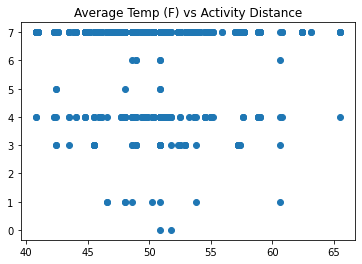

In [187]:
plt.figure()

#labels
plt.title("Average Temp (F) vs Activity Distance")

#plot
plt.scatter(merged_df["Avg Temp"], study_abroad_df["Activity"])
plt.show()
#

Testing to see if the avg distance is greater in the second half rather than first. 

In [188]:
first_half = study_abroad_df.iloc[0:322]
second_half = study_abroad_df[332:643]
print(first_half["Distance"].mean())
print(second_half["Distance"].mean())

6396.95652173913
11565.729032258065


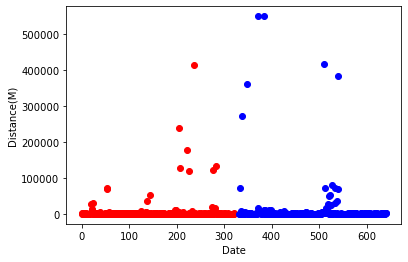

In [189]:
plt.figure()

#labels
plt.title("")
plt.xlabel("Date")
plt.ylabel("Distance(M)")

#plot
plt.scatter(first_half["Distance"].index, first_half["Distance"], color="red")
plt.scatter(second_half["Distance"].index, second_half["Distance"], color="blue")
plt.show()

is mean time spent on activity segments dependent on temp?

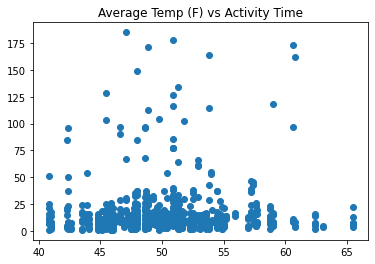

In [190]:
plt.figure()

#labels
plt.title("Average Temp (F) vs Activity Time")

#plot
plt.scatter(merged_df["Avg Temp"], study_abroad_df["Time Elapsed (min)"])
plt.show()

first vs second half time spent

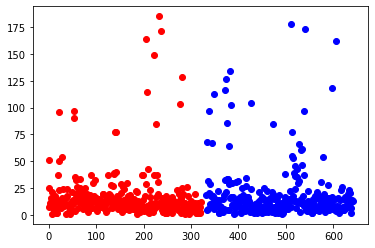

In [191]:
plt.figure()

#labels
plt.title("")

#plot
plt.scatter(first_half["Time Elapsed (min)"].index, first_half["Time Elapsed (min)"], color="red")
plt.scatter(second_half["Time Elapsed (min)"].index, second_half["Time Elapsed (min)"], color="blue")
plt.show()

avg time spain vs spokane

In [192]:
print(study_abroad_df["Time Elapsed (min)"].mean())
print(summer_df["Time Elapsed (min)"].mean())

17.53719093977153
19.760190955004596


## 3. Machine Learning  
In this section I will classify the data using the kNN algorithm and a Decision Tree Classiie.

In [193]:
from sklearn.neighbors import KNeighborsClassifier

In [194]:
from sklearn.tree import DecisionTreeClassifier